In [15]:
using CairoMakie
using JLD2
using Oceananigans
using ImageFiltering: imfilter, Kernel.gaussian

In [7]:
foldername = "../scratch/filament-instability/Ro1Ri1Ek0"
filename = "down_front_mean.jld2"
grid = jldopen("$foldername/$filename") do file
    file["serialized/grid"]
end;
xᶜᵃᵃ = xnodes(Center, grid)
zᵃᵃᶜ = znodes(Center, grid)
@inline function ∂zᶜᶜᶜ(aᶜᶜᶜ, Δzᵃᵃᶜ)
    let ∂zaᶜᶜᶜ = (aᶜᶜᶜ - circshift(aᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zaᶜᶜᶜ[:, 1] .= ∂zaᶜᶜᶜ[:, 2]
    ∂zaᶜᶜᶜ
    end
end
@inline function ∂xᶜᶜᶜ(aᶜᶜᶜ, Δx)
    (circshift(aᶜᶜᶜ, (-1, 0)) - circshift(aᶜᶜᶜ, (1, 0))) ./ (2Δx)
end

@inline function down_front_vorticity(runname, n)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    fluxfilename = "turbulent_flux.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    frame = frames[n]
    
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
    
    
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    
    file = jldopen("$foldername/$filename")
    fluxfile = jldopen("$foldername/$fluxfilename")
    
    u = file["timeseries/u_dfm/$frame"][:, 1, :]
    u1 = file["timeseries/u_dfm/$(frames[n+1])"][:, 1, :]
    v = file["timeseries/v_dfm/$frame"][:, 1, :]
    w = (file["timeseries/w_dfm/$frame"][:, 1, 2:end] .+ file["timeseries/w_dfm/$frame"][:, 1, 1:end-1])/2
    w1 = (file["timeseries/w_dfm/$(frames[n+1])"][:, 1, 2:end] .+ file["timeseries/w_dfm/$(frames[n+1])"][:, 1, 1:end-1])/2
    b = file["timeseries/b_dfm/$frame"][:, 1, :]
    ω = ∂xᶜᶜᶜ(w, Δx) - ∂zᶜᶜᶜ(u, Δzᵃᵃᶜ)
    ∂tω = (∂xᶜᶜᶜ(w1-w, Δx) - ∂zᶜᶜᶜ(u1-u, Δzᵃᵃᶜ)) / (file["timeseries/t/$(frames[n+1])"] - file["timeseries/t/$frame"])
    Dtω = ∂tω .+ u.*∂xᶜᶜᶜ(ω, Δx) .+ w.*∂zᶜᶜᶜ(ω, Δzᵃᵃᶜ)
    return (Dtω, ∂xᶜᶜᶜ(b, Δx) - sp.f * ∂zᶜᶜᶜ(v, Δzᵃᵃᶜ))
end

down_front_vorticity (generic function with 1 method)

In [28]:
a = down_front_vorticity("Ro1Ri02Ek0", 201);
σ = 1

1

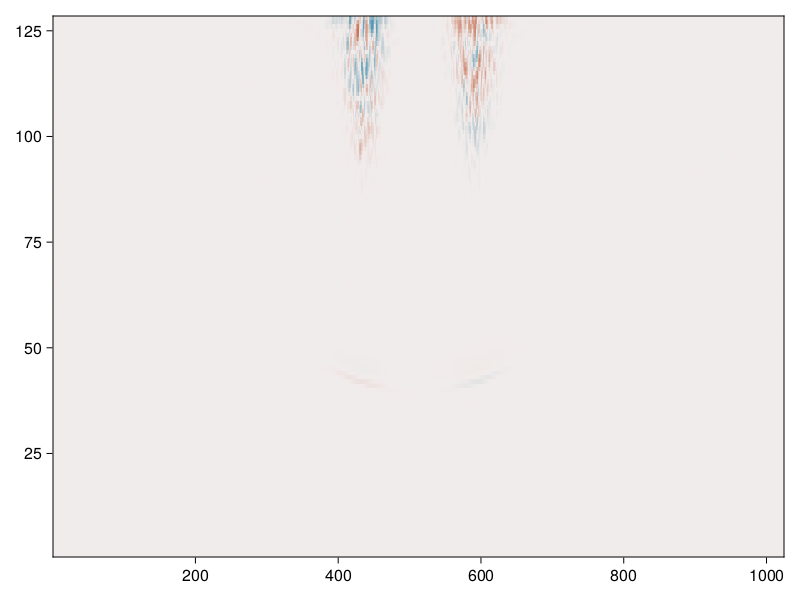

In [29]:
heatmap(imfilter(a[1], gaussian((σ, 0), (4σ+1, 5)), "circular"); colormap=:balance, colorrange=(-50, 50))

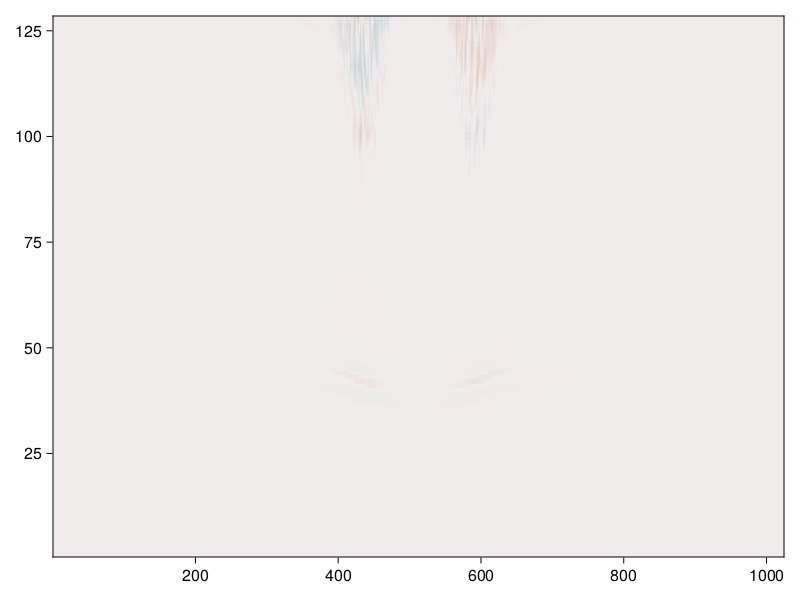

In [30]:
heatmap(imfilter(a[2], gaussian((σ, 0), (4σ+1, 5)), "circular"); colormap=:balance, colorrange=(-50, 50))